In [1]:
# Analyze Orcas Queries in Anchor Context

In [1]:
!pip3 install nltk termcolor

Defaulting to user installation because normal site-packages is not writeable


In [19]:
def normalize(text):
    import nltk
    nltk.data.path =  ['/mnt/ceph/storage/data-in-progress/data-research/web-archive/EMNLP-21/emnlp-web-archive-questions/cluster-libs/nltk_data']
    from nltk.stem import PorterStemmer
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    
    return [ps.stem(i) for i in word_tokenize(text) if i not in stop_words]

def weighted_representation(texts):
    from collections import defaultdict
    absolute_count = defaultdict(lambda: 0)
    for text in texts:
        for word in normalize(text):
            absolute_count[word] += 1
    
    return {k: v/len(texts) for k,v in absolute_count.items()}

def similarity(weights, text):
    text = set(normalize(text))
    ret = 0
    
    if text is None or len(text) == 0:
        return (0, 0.0)
    
    for k,v in weights.items():
        if k in text:
            ret += v
    
    covered_terms = 0
    for k in text:
        if k in weights:
            covered_terms += 1
            
    return (ret, covered_terms/len(text))

def __add_to_path(p):
    import sys
    if p not in sys.path:
        sys.path.append(p)

def domain(url):
    __add_to_path('/mnt/ceph/storage/data-in-progress/data-research/web-archive/EMNLP-21/emnlp-web-archive-questions/cluster-libs/tld')
    from tld import get_tld
    ret = get_tld(url, as_object=True, fail_silently=True)
    if ret:
        return ret.domain
    else:
        return 'None'

def identical_domain(i):
    return domain(i['document']['srcUrl']).lower() == domain(i['targetUrl']).lower()

def enrich_similarity(i):
    i = dict(i)
    weights = weighted_representation(i['orcasQueries'])
    contextSim = similarity(weights, i['anchorContext'])
    anchorSim = similarity(weights, i['anchorText'])
    i['anchorContextScore'] = contextSim[0]
    i['anchorContextCoveredTerms'] = contextSim[1]
    i['anchorTextScore'] = anchorSim[0]
    i['anchorTextScoreCoveredTerms'] = anchorSim[1]
    
    return i

def enrich_domain(i):
    i = dict(i)
    i['identical_domain'] = identical_domain(i)
    return i

In [20]:
normalize("Programmers program with programming languages")

['programm', 'program', 'program', 'languag']

In [21]:
weighted_representation(["Programmers program with programming languages"])

{'programm': 1.0, 'program': 2.0, 'languag': 1.0}

In [22]:
weighted_representation(["Programmers program with programming languages", "gameboys", "program the gameboy"])

{'programm': 0.3333333333333333,
 'program': 1.0,
 'languag': 0.3333333333333333,
 'gameboy': 0.6666666666666666}

In [23]:
enrich_similarity({"anchorText":"no match","anchorContext":"no match", "orcasQueries": ["Programmers program with programming languages", "gameboys", "program the gameboy"]})

{'anchorText': 'no match',
 'anchorContext': 'no match',
 'orcasQueries': ['Programmers program with programming languages',
  'gameboys',
  'program the gameboy'],
 'anchorContextScore': 0,
 'anchorContextCoveredTerms': 0.0,
 'anchorTextScore': 0,
 'anchorTextScoreCoveredTerms': 0.0}

In [24]:
enrich_similarity({"anchorText":"no match","anchorContext":"programmers programmers program", "orcasQueries": ["Programmers program with programming languages", "gameboys", "program the gameboy"]})

{'anchorText': 'no match',
 'anchorContext': 'programmers programmers program',
 'orcasQueries': ['Programmers program with programming languages',
  'gameboys',
  'program the gameboy'],
 'anchorContextScore': 1.3333333333333333,
 'anchorContextCoveredTerms': 1.0,
 'anchorTextScore': 0,
 'anchorTextScoreCoveredTerms': 0.0}

In [25]:
enrich_similarity({"anchorText":"gameboy program","anchorContext":"no match", "orcasQueries": ["Programmers program with programming languages", "gameboys", "program the gameboy"]})

{'anchorText': 'gameboy program',
 'anchorContext': 'no match',
 'orcasQueries': ['Programmers program with programming languages',
  'gameboys',
  'program the gameboy'],
 'anchorContextScore': 0,
 'anchorContextCoveredTerms': 0.0,
 'anchorTextScore': 1.6666666666666665,
 'anchorTextScoreCoveredTerms': 1.0}

In [47]:
# Evaluate it on many data points

In [16]:
import pyspark

sc = pyspark.SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [26]:
sc.parallelize(['https://www.definitions.net/definition/start', 'https://www.vizientinc.com/', 'https://foo.vizientinc.ca/']).map(domain).collect()

['definitions', 'vizientinc', 'vizientinc']

In [27]:
import json

#sc.textFile('ecir2022/anchor2query/anchor-text-with-orcas-queries-2019-47.jsonl')\
sc.textFile('ecir2022/anchor2query/anchor-text-with-orcas-queries-2019-47.jsonl/part*0{0,1,2,3,4}')\
    .repartition(5000)\
    .map(lambda i: json.loads(i))\
    .map(enrich_similarity)\
    .map(enrich_domain)\
    .map(lambda i: json.dumps(i))\
    .saveAsTextFile(path='ecir2022/anchor2query/anchor-text-with-orcas-queries-2019-47-enriched-5-percent-sample.jsonl', compressionCodecClass='org.apache.hadoop.io.compress.GzipCodec')

In [75]:
import json

anchor_text_sample = sc.textFile('ecir2022/anchor2query/anchor-text-with-orcas-queries-small.jsonl')\
    .map(lambda i: json.loads(i))\
    .map(enrich_similarity)\
    .collect()

print(len(anchor_text_sample))

36401


In [34]:
def keep_interesting_fields(i):
    return {
        'orcasQueries': len(i['orcasQueries']),
        'anchorContextScore': i['anchorContextScore'],
        'anchorContextCoveredTerms': i['anchorContextCoveredTerms'],
        'anchorTextScore': i['anchorTextScore'],
        'anchorTextScoreCoveredTerms': i['anchorTextScoreCoveredTerms'],
        'identical_domain': i['identical_domain']
    }

sc.textFile('ecir2022/anchor2query/anchor-text-with-orcas-queries-2019-47-enriched-5-percent-sample.jsonl')\
    .map(json.loads)\
    .map(keep_interesting_fields)\
    .map(json.dumps)\
    .repartition(100)\
    .saveAsTextFile(path='ecir2022/anchor2query/anchor-text-with-orcas-queries-2019-47-enriched-5-percent-sample-projection-for-overview.jsonl', compressionCodecClass='org.apache.hadoop.io.compress.GzipCodec')

In [ ]:
import pandas as pd

df = pd.read_json('/mnt/ceph/storage/data-in-progress/data-research/web-search/ECIR-22/ecir21-anchor2query/anchor-text-with-orcas-queries-2019-47-enriched-5-percent-sample-projection-for-overview.jsonl.gz', lines=True)
df

In [76]:
import pandas as pd

df = pd.DataFrame(anchor_text_sample)
df

,anchorText,anchorContext,targetUrl,targetMsMarcoDocIds,document,orcasQueries,anchorContextScore,anchorTextScore
0,https://www.google.com/chrome/browser/desktop/...,黛安芬-T-Shirt Bra M-EEL平口內褲 (灰)|F758311 - Triump...,https://www.google.com/chrome/browser/desktop/...,[D1001359],{'srcUrl': 'http://www.triumphshop.com.tw/Sale...,"[browser free download, chorm download, chrome...",0.676408,0.052744
1,Pingdom Monitoring,type Wheel Python version py2 Upload date Jan...,https://www.pingdom.com/,[D3235452],{'srcUrl': 'https://pypi.org/project/osio-api-...,"[website outages, pingdom tools, pingdom websi...",0.484848,0.484848
2,Weekly Ad,La Cuisine LC 2170MB PRO Round 5 Qt. Cast Iron...,https://weeklyad.target.com/,[D1982579],{'srcUrl': 'https://www.target.com/p/la-cuisin...,"[https://target, https://target/, local ads fo...",1.090395,0.263277
3,allied,used in flares / smoke bombs (and other simila...,https://en.wikipedia.org/wiki/Allies_of_World_...,[D23497],{'srcUrl': 'https://mikesjournal.blog/tag/amer...,"[wwii allied powers, wwii allies, allies and a...",1.007634,0.816794
4,Bootstrap,"STADELMAN, STEVEN (STEVE) - FollowTheMoney.org...",http://getbootstrap.com/,[D772300],{'srcUrl': 'https://www.followthemoney.org/ent...,"[bootstrap theme, popper js cdn, bootstrap sit...",0.568106,0.498339
...,...,...,...,...,...,...,...,...
36396,Website,an Restaurants (1) WebsiteView Menu (760) 366-...,http://www.morongocasinoresort.com,[D2857955],{'srcUrl': 'https://www.yellowpages.com/palm-s...,"[sage spa, cabazon casino, cabazon casino moro...",0.888889,0.000000
36397,WordPress,6.11.2019 Získejte průvodce světem sexu po men...,http://wordpress.org/,[D1963276],{'srcUrl': 'http://www.klubknihomolu.cz/58749/...,"[www.word press.com, wordpress web, wpordpress...",0.478261,0.304348
36398,University of California San Francisco,Career Tracks Group I and II: Manager and Supe...,http://www.ucsf.edu/,[D591139],{'srcUrl': 'https://hr.ucsf.edu/hr.php?B=4006&...,"[u of san francisco, university of california,...",1.604317,0.769784
36399,Library of Congress,"Peterson-Berger, Wilhelm, 1867-1942 - LC Linke...",https://loc.gov,[D271034],{'srcUrl': 'http://id.loc.gov/authorities/name...,"[congress for, crs.gov, internet archives, of,...",1.384615,1.065089


In [78]:
df['diff'] = df['anchorContextScore'] - df['anchorTextScore']
df.sort_values('diff')

,anchorText,anchorContext,targetUrl,targetMsMarcoDocIds,document,orcasQueries,anchorContextScore,anchorTextScore,diff
13421,Dispute resolution,法源位階體系及其名詞涵義 (PDF). 教育部及所屬機關學校公務糧倉. 2014-05-16...,https://en.wikipedia.org/wiki/Dispute_resolution,[D860643],{'srcUrl': 'https://zh.wikipedia.org/wiki/%E6%...,"[dispute resolution definition, methods of dis...",0.050000,1.800000,-1.750000
28578,Law enforcement,Talk:警務處處長 - 维基百科，自由的百科全书 首页 随机 附近 登录 设置 关于维基百...,https://en.wikipedia.org/wiki/Law_enforcement,[D466341],{'srcUrl': 'https://zh.m.wikipedia.org/wiki/Ta...,"[enforcement, legal enforcement, enforcing the...",0.000000,1.600000,-1.600000
29901,Dido's Lament,半音化四度 - 维基百科，自由的百科全书 半音化四度 维基百科，自由的百科全书 跳到导航 跳...,https://en.wikipedia.org/wiki/Dido%27s_Lament,[D1200725],{'srcUrl': 'https://zh.wikipedia.org/zh/%E5%8D...,"[when i am laid in earth, when i am laid in ea...",0.285714,1.428571,-1.142857
19823,Juno,Киносеанс. Юнона на авось. - Eye in the Sky — ...,http://www.imdb.com/title/tt0467406/,[D2460835],{'srcUrl': 'https://ctax.livejournal.com/66754...,"[juno, juno 2007, juno 2007 movie, juno charac...",0.000000,1.000000,-1.000000
15703,Technical diving,巧主要是會在越野賽中見到，因為越野賽的路面為一般道路或甚至無鋪面的礫石或塵土路面，除抓力較低...,https://en.wikipedia.org/wiki/Technical_diving,[D385728],{'srcUrl': 'https://zh.wikipedia.org/wiki/%E7%...,"[technical diving, tech diving, tec diving]",0.333333,1.333333,-1.000000
...,...,...,...,...,...,...,...,...,...
28471,cleared payment - opens in a new window or tab,Sellers set the item's declared value and must...,https://pages.ebay.com/help/buy/contextual/dom...,[D3385420],{'srcUrl': 'https://www.ebay.com/itm/Cut-Ritua...,[how to change handling time on ebay],4.000000,0.000000,4.000000
4432,Contact Us,Product ID: 2519961 Almost Gone! Men's Golden...,https://help-nba.custhelp.com/app/answers/deta...,[D144340],{'srcUrl': 'https://store.nba.com/golden-state...,[nba store customer service],4.000000,0.000000,4.000000
8355,Wedding,Preston Glass Sheet Music to Download [Top Qua...,https://www.virtualsheetmusic.com/Wedding.html,[D2759662],{'srcUrl': 'https://www.virtualsheetmusic.com/...,[free printable wedding sheet music],5.000000,1.000000,4.000000
10920,help?,Surat Thani (URT) to Rome (FCO) Flights | Thai...,https://www.thaiairways.com/en_TH/faq/index.page?,[D2119825],{'srcUrl': 'https://flights.thaiairways.com/en...,[thai airways change flight],4.000000,0.000000,4.000000


Matplotlib is building the font cache; this may take a moment.
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff', ylabel='Density'>

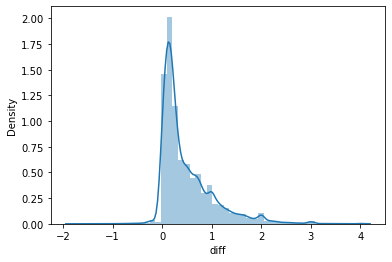

In [79]:
import seaborn as sb

sb.distplot(df['diff'])

In [83]:
len(df[(df['anchorTextScore'] <= 0.00001) & (df['anchorContextScore'] >= 0.1)])

3581

In [143]:
df_anchor_useless = df[(df['anchorTextScore'] <= 0.00001) & (df['anchorContextScore'] >= 0.1)].copy()



/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='anchorContextScore', ylabel='Density'>

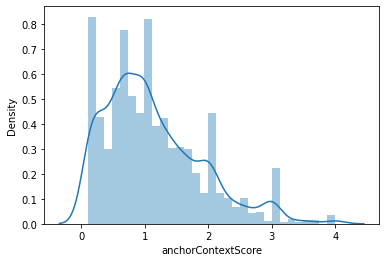

In [85]:
sb.distplot(df_anchor_useless['anchorContextScore'])

In [88]:
tmp = df_anchor_useless.sample(5)
tmp

,anchorText,anchorContext,targetUrl,targetMsMarcoDocIds,document,orcasQueries,anchorContextScore,anchorTextScore,diff
23216,Cart,SpikenzieLabs Robot Blinky Badge Bundle - Micr...,https://cart.microcenter.com/cart.aspx,[D2420600],{'srcUrl': 'https://www.microcenter.com/produc...,"[micro center madison heights, micro center ma...",1.666667,0.0,1.666667
5763,http://aidsinfo.nih.gov,f hepatitis B virus infection in the United St...,http://aidsinfo.nih.gov,"[D2478783, D3257169]",{'srcUrl': 'http://vacunasaep.org/documentos/m...,"[dhhs hiv, hiv guidelines, prevention of aids,...",0.824561,0.0,0.824561
7220,Also visit,ellers Home Of Classics Ultraboost Mini Me Sne...,https://www.reebok.com/us/,[D2897283],{'srcUrl': 'https://m.adidas.com/us/men-origin...,"[reebok x, reebok zigtech, reebok', reebok,com...",0.222222,0.0,0.222222
20729,Corporate Info,oyalty. These Nike pants feature awesome Carol...,http://www.fanaticsinc.com/,[D1668501],{'srcUrl': 'https://www.fanatics.com/nfl/carol...,"[fanaticks, wwwfanatics .com, fanatics, fanati...",0.838710,0.0,0.838710
3128,US,Model Magic Donut Dish | crayola.ca\r\n Contac...,http://www.crayola.com,[D2581459],{'srcUrl': 'http://www.crayola.ca/crafts/model...,"[crayola experience, crayola factory, cryola, ...",0.857143,0.0,0.857143


In [184]:
from termcolor import colored

def pretty_print_text(entry):
    weights = weighted_representation(entry['orcasQueries'])
    tmp = entry['anchorContext'].replace('\\s+', ' ')
    ret = ''
    for w in tmp.split(' '):
        crnt = w
        normalized_w = normalize(w)
        tmp_str = []
        
        for nw in normalized_w:
            if nw in weights:
                tmp_str += [nw + ':' + str(weights[nw])]
        
        if len(tmp_str) > 0:
            crnt += '[' + ( ';'.join(tmp_str) ) + ']'
            crnt = colored(crnt, 'red')
    
        ret += ' ' + crnt
    
    
    return ret.strip()
    

def pretty_print(entry):
    print('Document: ' + str(entry['document']['srcUrl']))
    print('OrcasQueries: ' + str(entry['orcasQueries']))
    
    print('Target\n\tUrl: ' + entry['targetUrl'])
    print('\tAnchor:\n\t\t\'' + entry['anchorText'] + '\'\n')
    print('\tAnchorContext: \'' + pretty_print_text(entry)+ '\'')

In [113]:
tmp_2 = df_anchor_useless.sample(5)
tmp_2

,anchorText,anchorContext,targetUrl,targetMsMarcoDocIds,document,orcasQueries,anchorContextScore,anchorTextScore,diff
3128,US,Model Magic Donut Dish | crayola.ca\r\n Contac...,http://www.crayola.com,[D2581459],{'srcUrl': 'http://www.crayola.ca/crafts/model...,"[crayola experience, crayola factory, cryola, ...",0.857143,0.0,0.857143
18523,Institution Website,mber Page 30 °f Clear Bethel University Royals...,http://www.stkate.edu/,[D851384],{'srcUrl': 'https://www.miacathletics.com/spor...,"[stcatherine, stcatherineuniversity, st. cathe...",1.212766,0.0,1.212766
9363,idrc.ca,enue un élément majeur du processus de fragili...,http://idrc.ca/en,[D2699037],{'srcUrl': 'https://idl-bnc-idrc.dspacedirect....,[idrc],1.000000,0.0,1.000000
35007,terms and conditions- opens in a new window or...,"ton-Cowes Ferry - Cowes Castle , built 1965 - ...",https://pages.ebay.co.uk/shipping/globalshippi...,[D1052826],{'srcUrl': 'https://www.ebay.co.uk/itm/SIM0039...,[global shipping programme],3.000000,0.0,3.000000
30205,พระพุทธรูปสำคัญในประเทศญี่ปุ่น,วงพ่อพุฒ หลวงพ่อยงยุทธ วัดเขาไม้แดง หลวงปู่ทวด...,http://www.onmarkproductions.com/html/big-budd...,[D1905742],{'srcUrl': 'http://beavis.tarad.com/product.de...,"[giant buddha japan, buddha in japan, big budd...",1.000000,0.0,1.000000


In [123]:
for _, i in tmp_2.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: http://www.crayola.ca/crafts/model-magic-donut-dish-craft/
Target
	Url: http://www.crayola.com
	Anchor:
		'US'

	AnchorContext: 'Model Magic[magic:0.012987012987012988] Donut Dish | crayola.ca
 Contact Us 1-800-272-9652 (1-800-CRAYOLA) Support Colouring Pages[page:0.09090909090909091] DIY Crafts Crayola[crayola:0.5064935064935064] Teachers Product[product:0.012987012987012988] Info Shop Online Australia Belgium Canada[canada:0.012987012987012988] China France Italy Japan Mexico Netherlands UK US Select Country Main Navigation Hide Navigation Home>Things To Do>Crafts Model Magic[magic:0.012987012987012988] Donut Dish Celebrate National Donut Day by creating a colourful, Model Magic[magic:0.012987012987012988] Donut Dish! Customize your donut with marbled techniques and bright Model Magic[magic:0.012987012987012988] sprinkles! 1. Roll out white Model Magic[magic:0.012987012987012988] to create the base of the dish. Use a small bow, placed upside down on the rolled out Model Mag

In [124]:
tmp_3 = df_anchor_useless.sample(5)
tmp_3

,anchorText,anchorContext,targetUrl,targetMsMarcoDocIds,document,orcasQueries,anchorContextScore,anchorTextScore,diff
1572,지원 제품,"Technet 포럼\r\n 이 사이트에서는 분석, 개인 설정 콘텐츠 및 광고를 위해...",https://www.microsoft.com/en-us/microsoftservi...,"[D832535, D582972]",{'srcUrl': 'https://social.technet.microsoft.c...,"[microsoft partners support, premier support, ...",1.625000,0.0,1.625000
2152,InsureKidsNow.govopens in new window,Search Results | CMS Resource Navigation opens...,https://www.insurekidsnow.gov,[D502564],{'srcUrl': 'https://www.cms.gov/newsroom/searc...,"[kids now, children's insurance, insurekidsnow...",0.692308,0.0,0.692308
6744,Cornell’s All About Birds,ies to practice for his first flight. Looks li...,https://www.allaboutbirds.org/guide/Red-tailed...,[D3376942],{'srcUrl': 'https://steiderstudios.wordpress.c...,"[red tail hawk facts, hawk nest, red tailed ha...",2.318182,0.0,2.318182
17504,NEURO/PSYCH,"Fluoroquinolone use is decreasing, apparently ...",http://drupal.org,[D1307559],{'srcUrl': 'https://blog.pharmacist.com/?q=nod...,"[cms drupal, durpal, durpalm, drupal org, drup...",0.172414,0.0,0.172414
2410,Learn More- opens in a new window or tab,sit eBay's page on international selling. Item...,https://pages.ebay.co.uk/shipping/globalshippi...,[D1052826],{'srcUrl': 'https://www.ebay.co.uk/itm/2mx1m-W...,[global shipping programme],3.000000,0.0,3.000000


In [125]:
for _, i in tmp_3.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: https://social.technet.microsoft.com/Forums/windows/ko-KR/home?forum=windowsxpzhchs&announcementId=2af65d3d-0106-4368-8aa2-04b25a2c0a42
Target
	Url: https://www.microsoft.com/en-us/microsoftservices/support.aspx
	Anchor:
		'지원 제품'

	AnchorContext: 'Technet 포럼
 이 사이트에서는 분석, 개인 설정 콘텐츠 및 광고를 위해 쿠키가 사용됩니다. 이 사이트 탐색을 계속하면 이러한 사용에 동의하게 됩니다. 자세히 보기 TechNet 제품 리소스 다운로드 학습 지원 제품 Windows Windows Server System Center Microsoft[microsoft:0.8125] Edge Office Office 365 Exchange Server SQL Server SharePoint 제품 Skype for Business 모든 제품 보기 » Resources Channel 9 Video 평가 센터 학습 리소스 Microsoft[microsoft:0.8125] Tech 도우미 앱 Microsoft[microsoft:0.8125] Technical Communities Microsoft[microsoft:0.8125] Virtual Academy 스크립트 센터 서버 및 도구 블로그 TechNet 블로그 TechNet 뉴스레터 TechNet 갤러리 TechNet 라이브러리 TechNet 잡지 TechNet Wiki Windows Sysinternals 가상 실습 Solutions 네트워킹 사설 클라우드 보안 가상화 업데이트 서비스 팩 보안 공지 Microsoft[microsoft:0.8125] Update 평가판 Windows Server 2016 System Center 2016 Windows 10 Enterprise[enterpris:0.125] 

In [127]:
tmp_4 = df_anchor_useless.sample(5)

In [128]:
for _, i in tmp_4.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: http://downunderdale.blogspot.com/2012/09/
Target
	Url: http://www.facebook.com/business/dashboard/
	Anchor:
		'The Thread Studio'

	AnchorContext: 'is time...... Posted by Downunderdale at 4:53 PM 2 comments:[::0.07142857142857142] Links to this post Email ThisBlogThis!Share to TwitterShare to FacebookShare to Pinterest Newer Posts Older Posts Home Subscribe to:[::0.07142857142857142] Posts (Atom) LinkWithin About Me Downunderdale Perth, Western Australia, Australia I am a textile artist and owner of The Thread Studio. I am passionate about all areas of textile art and try to be as cutting edge as I can. I enjoy machine and hand stitching, developing ideas using a needle felting machine and playing and experimenting with all manner of textiley and mixed media stuff. I guess I am an art journaller of a different variety before the title became trendy but my journals are more the stitchy variety than the paper types. I have been a teacher for many years and run a number of on-

In [129]:
tmp_5 = df_anchor_useless.sample(5)

In [130]:
for _, i in tmp_5.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: https://www.datsun.co.za/datsun-financial-solutions.html
Target
	Url: http://www.datsun.com/
	Anchor:
		'Global Site'

	AnchorContext: 'PV 149 900 11.40% 72 0% 2 396 35% 2 464 227 435 Datsun[datsun:0.47058823529411764] Financial Solutions Notice: the monthly instalment and total cost of credit included Bank Initiation fees incl. VAT and a monthly service fee (R68.00 p/m), but excludes mandatory insurances.* Finance subject to credit vetting and approval from Datsun[datsun:0.47058823529411764] Financial Solutions, a product of WesBANK, a division on the First Rand Bank Ltd, an Authorised Financial Services and Registered Credit Provider, NCRCP20. Offer valid from 01 February 2017 - 31 March 2017 and subject to stock availability. Prices and specifications subject to change without prior notification. Recommended retail price excludes PDI, all on road costs (licence& registration) and accessories. Derivative shown in the table above, unless otherwise stated, all amounts are inc

In [148]:
len(df_anchor_useless[df_anchor_useless['identical_domain'] == False])

2203

In [149]:
tmp_6 = df_anchor_useless[df_anchor_useless['identical_domain'] == False].sample(5)

In [153]:
df_anchor_useless['identical_domain'] = df_anchor_useless.apply(lambda i: identical_domain(i), axis=1)
df_anchor_useless['numberOrcasQueries'] = df_anchor_useless['orcasQueries'].apply(lambda i: len(i))

In [154]:
df_anchor_useless.sort_values('numberOrcasQueries')

,anchorText,anchorContext,targetUrl,targetMsMarcoDocIds,document,orcasQueries,anchorContextScore,anchorTextScore,diff,identical_domain,numberOrcasQueries
26308,Coach,All Science Fair Projects Science Project Foru...,http://www.all-science-fair-projects.com/scien...,[D2472744],{'srcUrl': 'http://classroom.all-science-fair-...,[science fair introduction example],2.000000,0.0,2.000000,True,1
3918,Terms of use,"шит. Я расскажу о его истории, покажу современ...",https://www.google.com/intl/en/policies/terms/,[D2697773],{'srcUrl': 'https://samsebeskazal.livejournal....,[google maps english language],3.000000,0.0,3.000000,False,1
18069,Watch Video,r a difference in sound. Azzolini plays a peri...,http://video.indianapublicmedia.org/,[D2864235],{'srcUrl': 'https://indianapublicmedia.org/har...,[indiana public media],3.000000,0.0,3.000000,True,1
18152,PRICING,User statistics for: hlm193 TOUR PRICING HELP...,http://www.stencyl.com/pricing/,[D2064880],{'srcUrl': 'http://community.stencyl.com/index...,[stencyl],1.000000,0.0,1.000000,True,1
18155,HFM Magazine,ne from pop music stars to corporate big shots...,http://www.hfmmagazine.com,[D571556],{'srcUrl': 'https://www.hhnmag.com/articles/41...,[health facilities management],1.000000,0.0,1.000000,False,1
...,...,...,...,...,...,...,...,...,...,...,...
26393,Mac/PC,Share on WhatsApp English ▾ Select your langua...,https://www.whatsapp.com/download/,"[D1764408, D797874]",{'srcUrl': 'https://api.whatsapp.com/send?text...,"[app web, app web whatsapp, atualizar whatsapp...",0.896325,0.0,0.896325,True,8382
17737,Mac/PC,Share on WhatsApp English ▾ Select your langua...,https://www.whatsapp.com/download/,"[D1764408, D797874]",{'srcUrl': 'https://api.whatsapp.com/send?text...,"[app web, app web whatsapp, atualizar whatsapp...",0.896325,0.0,0.896325,True,8382
20732,Speedtest®,rld Standard in Internet Metrics Enterprise Sp...,https://www.speedtest.net/,"[D1684072, D627688]","{'srcUrl': 'https://www.ookla.com/', 'recordID...","[adsl speed, at&t internet test, broadband spe...",1.377035,0.0,1.377035,False,10686
20684,Kattints ide a sávszélességed ellenőrzéséhez,"Utáljuk azt hallani, hogy nem működünk, ezért...",http://www.speedtest.net/,"[D1684072, D627688]",{'srcUrl': 'https://indavideo.hu/hibabejelento...,"[adsl speed, at&t internet test, broadband spe...",0.231424,0.0,0.231424,False,10686


In [150]:
for _, i in tmp_6.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: https://www.nyknicksstore.com/help/interest_based_advertising
Target
	Url: https://nba.com/knicks
	Anchor:
		'NBA.com/Knicks'

	AnchorContext: 'Skip to Main ContentSkip to Footer SIGN UP & SAVE 10% NBA.com/Knicks Gift Cards Track Order Help My Account[account:0.017699115044247787] FanCashLearn More FanCashLearn More men AccessoriesFootwearHatsHome & Office Hoodies & SweatshirtsJacketsJerseysPants PolosShirts & SweatersShortsSleepwear & Underwear Swim CollectionT-ShirtsTailgatingBig & Tall women AccessoriesBagsDressesFootwearHats Home & OfficeHoodies & SweatshirtsJacketsJerseysPants PolosShirts & SweatersShortsSleepwear & Underwear Swim CollectionT-ShirtsTailgatingPlus Sizes kids AccessoriesFootwearHatsHome & Office Hoodies & SweatshirtsJacketsJerseys PantsRompersShorts Sleepwear & UnderwearSwim CollectionT-Shirts more jerseys t-shirts sweatshirts hats knicks[knick:0.5132743362831859] gaming[game:0.07964601769911504] collectibles new[new:0.3185840707964602] arrivals jerseys Me

In [156]:
len(df_anchor_useless[(df_anchor_useless['identical_domain'] == False) & (df_anchor_useless['numberOrcasQueries'] < 10)])

657

In [157]:
tmp_7 = df_anchor_useless[(df_anchor_useless['identical_domain'] == False) & (df_anchor_useless['numberOrcasQueries'] < 10)].sample(5)

In [161]:
for _, i in tmp_7.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: https://apnews.com/d74632071fe342d0831b6098629ca87b
Target
	Url: https://www.ap.org/about
	Anchor:
		'About'

	AnchorContext: 'st enough to get a quick take on who’s who and where they came from. The other “Defenders” are Luke Cage (Mike Colter), newly released from prison and ready to return to being the Hero of Harlem; Matt Murdock (Charlie Cox), who is trying desperately to leave his alter-ego as Daredevil behind him; and Danny Rand (Finn Jones), the boy billionaire known as the Iron Fist. Alexandra has her own superheroine to make sure she achieves her goal of flattening Gotham, someone with personal ties to one of the Defenders. Weaver is great fun to watch, especially because her acting style is so carefully reserved in comparison to the actors playing “The Defenders.” It has to be said, though, that her character’s taste in couture is really atrocious for someone who is supposed to be filthy rich. Most of her schmatas wouldn’t make the former Home Shopping Network’s 3 

In [162]:
tmp_8 = df_anchor_useless[(df_anchor_useless['identical_domain'] == False) & (df_anchor_useless['numberOrcasQueries'] < 10)].sample(5)

In [163]:
for _, i in tmp_8.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: http://paleofreak.blogalia.com/etiquetas/especies
Target
	Url: http://www.talkorigins.org/
	Anchor:
		'The Talk.Origins archive'

	AnchorContext: 'El PaleoFreak - Etiquetas Yo no tuve infancia; tuve prehistoria el PaleoFreak | portada | archivo | contacto Blog sobre evolución y temas afínidos ¡Twitter! twitter.com/paleofreak Seguir a @paleofreak Temas Biologia Creacionismo y religion Especulacion FAQ Filogenia Paleofrikadas Paleoilustracion Paleontologia Prensa y divulgacion Temas varios Teoria de la evolucion Comentarios recientes Dave Mcflurry en Montaje de un titanosaurio Sue en Más dinosaurios ¿? Sue en Cavernícola gay yas en Nyctosaurus sebulbai, por Qilong Sue en Montaje de un titanosaurio Sue en Dinosaurios, ¿nueva clasificación? (vídeo de El Pakozoico) Anónimo en Canguros II Sue en El insecto viene del crustáceo Sue en Xyloplax, el desclasado Sue en Un Adriosaurus con los brazos a la mitad El Libro: Una carta, no demasiado cordial, a un creata. Comprar el libro. Colec

In [164]:
tmp_9 = df_anchor_useless[(df_anchor_useless['identical_domain'] == False) & (df_anchor_useless['numberOrcasQueries'] < 10)].sample(5)

In [165]:
for _, i in tmp_9.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: http://java.ulitzer.com/node/2336017
Target
	Url: http://cloudcomputingexpo.com/
	Anchor:
		'Volunteers'

	AnchorContext: 's Hosted Delivery Platform To Enable Enterprise Open Source Adoption How To Deploy Scalable WebSphere Applications Using "Maven" Build Tool Automatic Integration with CruiseControl.NET, NAnt, and NUnit Maven: A Different Way of Looking at Software Development An Introduction to Maven - Part III Open BlueDragon Computers[comput:0.16666666666666666] and Software The Shape of i-Technology To Come: Predictions for 2006 AJAX and Microsoft's Atlas To Dominate the Shape of i-Technology AJAX Tipped To Play Major Role in the Shape of i-Technology to Come Setting Up Your Development Server with ColdFusion 5, MX, and BlueDragon Creating a Remember Me Login Online Shopping Retail Rich Internet Applications - State of the Union Using the CASE Expression in SQL Queries The Development Power of Open Source AJAX Tooling Amazon - The Real Web Services Company How to Secur

In [175]:
df_anchor_and_context_useful = df[(df['anchorTextScore'] >= 0.2) & (df['anchorContextScore'] > df['anchorTextScore'])].copy()
df_anchor_and_context_useful['identical_domain'] = df_anchor_and_context_useful.apply(lambda i: identical_domain(i), axis=1)
df_anchor_and_context_useful['numberOrcasQueries'] = df_anchor_and_context_useful['orcasQueries'].apply(lambda i: len(i))


In [167]:
len(df_anchor_and_context_useful)

23193

In [177]:
tmp_10 = df_anchor_and_context_useful[(df_anchor_and_context_useful['identical_domain'] == False) & (df_anchor_and_context_useful['numberOrcasQueries'] < 10)].sample(5)

In [178]:
for _, i in tmp_10.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: https://marketplace.xbox.com/en-US/Product/Danger-Close-Hoodie/00000208-5909-5282-c29e-8f8445410993
Target
	Url: https://www.microsoft.com/en-us/windows/windows-10-apps
	Anchor:
		'Windows apps'

	AnchorContext: 'Danger Close Hoodie Skip to main content Microsoft[microsoft:0.16666666666666666] Xbox Home Game Pass Overview Browse Games Xbox Game Pass for PC Xbox Live Gold Games Games home Console games Xbox One games Xbox 360 games Games with Gold Deals with Gold Xbox One X Enhanced games Backward compatible games PC games PC gaming with Xbox Xbox Game Pass Xbox Play Anywhere Xbox Game Streaming (Preview) Redeem Code Sales & Specials Devices Xbox One consoles Meet Xbox One Xbox One X Xbox One S Xbox All Access Shop Consoles Console Companion app[app:1.0] Gaming PCs Accessories Where to Buy Deals Community Xbox Community Xbox Live Gold Mixer Esports Xbox Official Gear For Everyone Our philosophy Responsible gaming Accessible gaming My Xbox Home Profile Achievements Friends Mess

In [179]:
tmp_11 = df_anchor_and_context_useful[(df_anchor_and_context_useful['identical_domain'] == False) & (df_anchor_and_context_useful['numberOrcasQueries'] < 10)].sample(5)

In [185]:
for _, i in tmp_11.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: https://www.gaylordlittleleague.com/default.aspx?portalid=7651
OrcasQueries: ['little league', 't ball ages', 'tball near me']
Target
	Url: http://www.littleleague.org/learn/about/divisions/TeeBallDivision.htm?
	Anchor:
		'Tee Ball 10-Week Program'

	AnchorContext: 'Home
 Home SKILLS ASSESSMENT UMPIRE RESOURCES OUR FIELDS COACHES CORNER Coaching Resources Concussion Information Coach Pitch 12-Week Program Tee Ball[ball:0.3333333333333333] 10-Week Program SKILLS ASSESSMENT AND DRAFT PROCEDURES FORMS DIVISIONS Tee Ball[ball:0.3333333333333333] 4 1/2 - 6 Yrs (co-ed) Coach Pitch 7-8 Yrs SUPER MINORS 9-10 Yrs MAJORS 11-12 Yrs JUNIORS 13-15 Yrs BASEBALL AGE[age:0.3333333333333333] CHART SOFTBALL AGE[age:0.3333333333333333] CHART VOLUNTEER CLINICS SPONSORS GALLERY 2019 SCHEDULES FAQ LEAGUE[leagu:0.3333333333333333] INFO BOARD MEMBERS BOARD MEETING MINUTES Login Register Website Manager We are in need of a new player agent/vice president of softball!!! We will train you! Let us know 

In [181]:
tmp_12 = df_anchor_and_context_useful[(df_anchor_and_context_useful['identical_domain'] == False) & (df_anchor_and_context_useful['numberOrcasQueries'] < 10)].sample(5)

In [186]:
for _, i in tmp_12.iterrows():
    pretty_print(i)
    print('\n\n\n')

Document: http://rizkyfebriyantoprasetyo.blog.unesa.ac.id/?p=5
OrcasQueries: ['free online counter', 'online counter', 'flag counter', 'sub counter', 'free hit counter']
Target
	Url: http://www.supercounters.com
	Anchor:
		'Tumblr Hit Counter'

	AnchorContext: 'ng putri Anda. Disini kami sajikan beberapa nama yang bisa Anda pilih untuk bayi perempuan Anda. Dimana nama-nama ini berdasarkan corak bahasa dari beberapa bahasa negara lain yang telah diadopsi ke dalam bahasa Indonesia. Namun sebelumnya, tentunya dalam memberikan sebuah nama tidak terlepas dari pengalaman Anda, harapan Anda, karakter dari sang anak, dan juga bisa dalam bentuk penanda momen tertentu. Pemberian nama memang sedikit menyulitkan bagi sebagian orang. Karena memang banyak faktor yang Anda pikirkan. Disamping itu nama yang akan Anda berikan kepada sang buah hati tentunya akan dibawanya hingga dewasa. Dengan Read More… 1 2 3 4 5 6 7 8 9 10 Hi I'm Rizky Febriyanto Prasetyo Archives 2017 September 2017 Oktober 2017 Nove